# Goal:
Generate dataset with fixed covariates (nodes) and all possible effect sizes (edges) and recover this effect sizes using OOD counterfactual test datasets. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# print date and time
from datetime import datetime
start_time = datetime.now()
print("Notebook started on {}".format(str(start_time).split(".")[0]))

Notebook started on 2024-12-17 16:07:42


In [2]:
# standard python packages
import os, sys
from math import exp, log
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# from tqdm.notebook import tqdm
from copy import deepcopy
from glob import glob
from tqdm import tqdm
from joblib import Parallel, delayed   
import itertools

from pprint import pprint

# import functions from Toybrains utils
TOYBRAINS_DIR = os.path.abspath('../../')
if TOYBRAINS_DIR not in sys.path: sys.path.append(TOYBRAINS_DIR)
from create_toybrains import ToyBrainsData
from utils.vizutils import show_contrib_table
from utils.genutils import gen_toybrains_dataset
from utils.genutils_all import *

## Dataset generation settings

In [3]:
# Sections to run 
GEN_DATASETS=True
N_SAMPLES=5000
N_SAMPLES_TEST=500
TEST_ON_OOD=True
GEN_IMAGES=False
DATASET_SUFFIX=''
OVERWRITE_EXISTING=True
VERBOSE=0

VIZ_DAG=False
VIZ_DISTS_BEFORE=False
VIZ_DISTS_AFTER=False
VIZ_IMG_SAMPLES=False and GEN_IMAGES
GEN_BASELINES=True
VIZ_BASELINE=True and GEN_BASELINES
BASELINE_MODELS= [('LR', {}), 
                # ('LR', {'C':0.0001}), ('LR', {'C':0.0002}), ('LR', {'C':0.0005}), ('LR', {'C':0.001}), ('LR', {'penalty': None}),
                # ('SVM', {}),
                 ]
BASELINE_METRICS=['balanced_accuracy', 
                  'd2', 'logodds_r2', 
                  'logodds_mae','logodds_mse'
                 ] #,'roc_auc', 'adjusted_mutual_info_score'

## (1) Create the data generation graph

#### (1a) What values to set the $\beta$, $\gamma$, and $\alpha$ values? 


In [4]:
eff_to_proba = lambda z: exp(z)/(1+exp(z))
proba_to_eff = lambda p: log(p/(1-p))

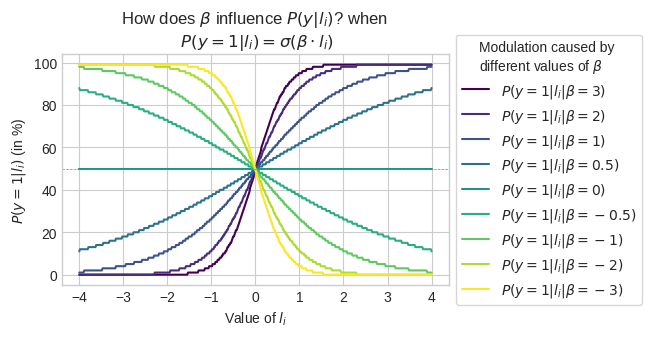

In [5]:
df = []
for eff in np.linspace(-4, 4, 500):
    df.append({'eff': eff, 
                r'$P(y=1|l_i|\beta=3)$' : int(eff_to_proba(3*eff)*100),
                r'$P(y=1|l_i|\beta=2)$' : int(eff_to_proba(2*eff)*100),
                r'$P(y=1|l_i|\beta=1)$' : int(eff_to_proba(eff)*100),
                r'$P(y=1|l_i|\beta=0.5)$' : int(eff_to_proba(0.5*eff)*100),
                r'$P(y=1|l_i|\beta=0)$' : int(eff_to_proba(0)*100),
                r'$P(y=1|l_i|\beta=-0.5)$': int(eff_to_proba(-0.5*eff)*100),
                r'$P(y=1|l_i|\beta=-1)$': int(eff_to_proba(-eff)*100),
                r'$P(y=1|l_i|\beta=-2)$': int(eff_to_proba(-2*eff)*100),
                r'$P(y=1|l_i|\beta=-3)$': int(eff_to_proba(-3*eff)*100),
               })
df = pd.DataFrame(df)
df.set_index('eff', inplace=True)
df.plot(colormap='viridis', figsize=(5, 3))
# move legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, title='Modulation caused by \ndifferent values of $\\beta$')
plt.xlabel('Value of $l_i$')
plt.ylabel('$P(y=1|l_i)$ (in %)')
plt.title('How does $\\beta$ influence $P(y|l_i)$? when \n $P(y=1|l_i)  = \\sigma(\\beta \\cdot l_i)$')
plt.axhline(50, color='grey', linestyle='--', linewidth=0.5)
plt.show()

In [6]:
# Reformulate the effect size as percentages before storing it in the dataset's name.
EFFECT_MUL = lambda eff: int(eff_to_proba(eff)*100)

### (1a) Sample 100 Covariates and label

In [7]:
n_covs = 100
n_covs_lbl = 1 # number of Covariates influencing label
n_covs_enc = 1 # number of Covariates influencing both attributes and label (confounders)

CON_TYPE_SHOULD_BE = lambda con: 'cont' in con
# CON_TYPE_SHOULD_BE = lambda con: ('cat' in con) and (int(con.split('_')[-1].replace('cat',''))==2)
# CON_TYPE_SHOULD_BE = lambda con: ('cat' in con) and (int(con.split('_')[-1].replace('cat',''))>2)
L_TYPE_SHOULD_BE = lambda l: 'int' not in l # don't use categorical latents for now

## Configure the effects
# effect of the true signal on the label # NOTE: the probability of the variable is (effect/(1+effect))
EFFECT_LDIR_TO_YS = [0, 0.75, 1.5, 2.5]#[0.75, 1, 1.25, 1.5, 1.75, 2] 
EFFECT_CON_TO_YS  = [0, 0.75, 1.5, 2.5]#[0.75, 1, 1.25, 1.5, 1.75, 2]
EFFECT_CON_TO_LS  = [0, 0.75, 1.5, 2.5]#[3] 

# create all combinations of the effect sizes
combinations = list(itertools.product(EFFECT_LDIR_TO_YS, EFFECT_CON_TO_YS, EFFECT_CON_TO_LS))

# fix the effects of noise
EFFECT_NOISE_TO_Y = 0.75 # currently not used
EFFECT_COV_TO_L = 5

TWEAK_STEPS = len(combinations)
if VERBOSE>0: print(f"{TWEAK_STEPS} number of dataset variations will be generated")

In [8]:
# a list of all the generative attributes in Toybrains
tb = ToyBrainsData()
display(tb.show_all_states())

attrs = sorted(list(tb.GENVARS.keys()))
if VERBOSE>0: print(f"Total generative parameters in Toybrains = {len(attrs)}: ")

# attributes that are reserved from label y
lat_direct = 'shape-midr_vol'
if VERBOSE>0: print(f"The 'direct' influence on label y is from {lat_direct}")


Image attributes (fixed):
Name                States                                                                      Weights
------------------  --------------------------------------------------------------------------  -------------------------------------------------
brain-vol_radminor  [20 21 22 23 24]                                                            [0. 0. 0. 0. 0.]
brain-vol_radmajor  [26 27 28 29 30]                                                            [0. 0. 0. 0. 0.]
brain_thick         [1 2 3 4]                                                                   [0. 0. 0. 0.]
brain-int_fill      [210 200 190 180 170]                                                       [0. 0. 0. 0. 0.]
brain-int_border    ['0-mediumslateblue' '1-slateblue' '2-darkslateblue' '3-darkblue']          [0. 0. 0. 0.]
vent_thick          [1 2 3 4]                                                                   [0. 0. 0. 0.]
shape-top_int       ['0-indianred' '1-salmon' '2-light

None

### (1b) Create the config file (generative structural graph)

1) Sample 100 covariate names and their datatypes (states) that can be either categorical-binary (33%), categorical-multiclass(33%), or continuous (34%)


In [9]:
covs = sample_covars(n_covs, ctype_probs={'cont':0.3, 'cat2':0.3, 'catn':0.4})
if VERBOSE>0:
    ctypes_count = pd.Series([k.split('_')[-1] for k in covs.keys()]).value_counts().sort_index()
    print(f"sampled {n_covs} random covariates with datatypes: \n{ctypes_count}")

In [10]:
# call the sampler repeatedly until the covariates dtype is what is expected in CON_TYPE_SHOULD_BE
if 'CON_TYPE_SHOULD_BE' not in globals() or CON_TYPE_SHOULD_BE is None:
    covs_to_lats, covs_lbl, covs_con = sample_influential_covars(
                                                                covs, attrs, 
                                                                n_covs_enc, 
                                                                n_covs_lbl=n_covs_lbl, 
                                                                lat_direct=lat_direct,
                                                                verbose=1)
else:
    CORRECT_CON_TYPE = False
    CORRECT_L_TYPE = False
    while not (CORRECT_CON_TYPE and CORRECT_L_TYPE):
        covs_to_lats, covs_lbl, covs_con = sample_influential_covars(
                                                                    covs, attrs, 
                                                                    n_covs_enc, 
                                                                    n_covs_lbl=n_covs_lbl,
                                                                    lat_direct=lat_direct,
                                                                    verbose=1)
        CORRECT_CON_TYPE = np.array([CON_TYPE_SHOULD_BE(c) for c in covs_con]).all()
        l_indir = [covs_to_lats[c] for c in covs_con]
        CORRECT_L_TYPE = np.array([L_TYPE_SHOULD_BE(l) for l in l_indir]).all()
        if not CORRECT_CON_TYPE:
            print(f"dtype of the Confound is not as expected, resampling everything...")
        if not CORRECT_L_TYPE:
            print(f"dtype of the latent influencing label is not as expected, resampling everything...")

covs_attrs = sorted(list(covs_to_lats.keys()))

Other covariates that influence the label  (c-->y) = ['cov_54_cont']
Covariates chosen as confounder        (L<--c-->y) = ['cov_54_cont']
Covariates that influence img. attributes  (L<--c) = {'cov_68_cat2': 'shape-botl_vol', 'cov_38_cat3': 'brain-int_fill', 'cov_46_cat4': 'brain_thick', 'cov_48_cat3': 'shape-midr_int', 'cov_79_cat4': 'brain-vol_radminor', 'cov_39_cat2': 'brain-int_border', 'cov_72_cat3': 'shape-botr_int', 'cov_6_cat2': 'shape-top_vol', 'cov_42_cont': 'vent_thick', 'cov_98_cat2': 'shape-midl_vol', 'cov_75_cat3': 'shape-botl_int', 'cov_37_cat5': 'shape-botr_vol', 'cov_35_cont': 'shape-midl_int', 'cov_28_cont': 'brain-vol_radmajor', 'cov_54_cont': 'shape-top_int'}
dtype of the latent influencing label is not as expected, resampling everything...
Other covariates that influence the label  (c-->y) = ['cov_86_cat5']
Covariates chosen as confounder        (L<--c-->y) = ['cov_86_cat5']
Covariates that influence img. attributes  (L<--c) = {'cov_60_cat2': 'brain-int_border', 'co

2) Create a base config file:
<br>
    a) Define the covariates dict `COVARS`

In [11]:
COVARS = {'lbl_y'  : dict(states=['s0', 's1'])}
COVARS.update({ci: dict(states=covs[ci])for ci in list(set(covs_attrs+covs_lbl))})

if VERBOSE>0: pprint(COVARS)

2) Create a base config file:


In [12]:
RULES_TWEAKED_ALL = []

for EFFECT_TRUE_TO_Y, EFFECT_CON_TO_Y, EFFECT_CON_TO_G  in combinations:

    if VERBOSE>0: print(f"{'-'*100} \n Effect sizes: \n\t True --> Y = {EFFECT_TRUE_TO_Y} \n\t Cov --> Y = {EFFECT_CON_TO_Y} \n\t Cov --> G = {EFFECT_CON_TO_G}")

    ##### b) i) Define the 'true effect' rule of $g \mapsto y$ (EFFECT_TRUE_TO_Y)
    rule_true = get_rule_for_cov(cov_name='true_cont',  # the 'true' attribute is a generative parameter that is a continuous variable
                                ci_states=tb.GENVARS[lat_direct].states.astype(int).tolist(), 
                                attr='lbl_y', attr_states_n=2,
                                effect_size=EFFECT_TRUE_TO_Y, verbose=VERBOSE-1)

    rules = {lat_direct: rule_true}

    ##### b) ii) Define the other effects on y: $c \mapsto y$ (EFFECT_NOISE_TO_Y and EFFECT_CON_TO_Y)
    # then the other cov-->y effects
    for ci in covs_lbl:
        effect_size = EFFECT_CON_TO_Y if ci in covs_con else EFFECT_NOISE_TO_Y
        rule = get_rule_for_cov(cov_name=ci, 
                                ci_states=covs[ci], 
                                attr='lbl_y', attr_states_n=2,
                                effect_size=effect_size, verbose=VERBOSE)
        rules.update({ci: rule})

    ##### b) iii) finally, the effects of c-->g (EFFECT_COV_TO_L)    
    for ci, attri in covs_to_lats.items():
        effect_size = EFFECT_CON_TO_G if ci in covs_con else EFFECT_COV_TO_L

        rule = get_rule_for_cov(cov_name=ci, 
                                ci_states=covs[ci],
                                attr=attri,
                                attr_states_n=tb.GENVARS[attri].k,
                                effect_size=effect_size,
                                verbose=VERBOSE)

        if ci in covs_con: # then the ci is already in the rules dict
            for state in rules[ci]:
                rules[ci][state].update(rule[state]) 
        else:
            rules.update({ci: rule})
    
    dataset_name = make_dataset_name(covs_con,
                                    cX = EFFECT_CON_TO_G,
                                    cy = EFFECT_CON_TO_Y, 
                                    Xy = EFFECT_TRUE_TO_Y,
                                    suffix = DATASET_SUFFIX,
                                    effect_mul = EFFECT_MUL)

    RULES_TWEAKED_ALL.append([dataset_name, deepcopy(rules)])

if VERBOSE>0: print(f"Created dataset variations: \n {list(zip(*RULES_TWEAKED_ALL))[0]}")

In [13]:
# throw error when the keys of RULES_TWEAKED_ALL are not unique
tweaked_names = sorted(list(zip(*RULES_TWEAKED_ALL))[0])
assert tweaked_names == sorted(list(set(tweaked_names))), f"Dataset variation names are not unique! = {pprint(tweaked_names)}"

In [14]:
##### Create config directory 
config_dirname = 'configs' #  a folder to save all the configs
if not os.path.exists(config_dirname):
    os.makedirs(config_dirname)

### (1c) Viz the configured dists. before data generation

In [15]:
# visualize the causal generative graph of the training data
if VIZ_DAG:
    # choose one of the dataset variation
    dataset_name, rules = deepcopy(RULES_TWEAKED_ALL[-1])

    # first create the base config file
    config_fname = f'{config_dirname}/{dataset_name}.py'
        
    gen_toybrains_dataset(
                    config_fname, COVARS, rules, 
                    config_write_kwargs= {"LATENTS_DIRECT"   : [lat_direct], 
                                          "LATENTS_INDIRECT" : covs_enc, 
                                          "COV_TO_LATENTS"   : covs_to_lats,
                                          "COV_TO_LABEL"     : covs_lbl,
                                          },
                    n_samples=10,
                    show_dag=True, show_probas=None,
                    return_baseline_results = False,
                    gen_images=False,
                    overwrite_existing=True, 
                    verbose=VERBOSE)

    # delete the generated config file and dataset
    # !rm -v $config_fname

In [16]:
if VIZ_DISTS_BEFORE:
    
    print("Configured distributions of the image attributes:")

    cX_last, cy_last, Xy_last = None, None, None
    
    for dataset_name, rules_i in RULES_TWEAKED_ALL:
        print(f"{'-'*50} \t{dataset_name}\t {'-'*50}")

        # only show the probas of the factors that change
        n_cons, cons, cX, cy, Xy, suffix =  break_dataset_name(dataset_name, effect_mul=EFFECT_MUL)
        
        # for the first one show all the probas
        if cX_last == None and cy_last == None and Xy_last == None:
            show_probas = ['all']
        else:
            show_probas = set([])
            if cX != cX_last or cy != cy_last: [show_probas.add(c.replace('-','_')) for c in cons]
            if Xy != Xy_last: show_probas.add(lat_direct)
            show_probas = list(show_probas)

        # create a toybrains object with the config file
        config_fname = f'{config_dirname}/{dataset_name}-dummy.py'
        gen_toybrains_dataset(
                    config_fname, COVARS, deepcopy(rules_i), 
                    show_probas=show_probas, show_dag=False, n_samples=100,
                    return_baseline_results = False,
                    gen_images=False,
                    overwrite_existing=True,
                    verbose=False)

        if cX != cX_last: cX_last = cX
        if cy != cy_last: cy_last = cy
        if Xy != Xy_last: Xy_last = Xy
        

## (2) Generate dataset

In [17]:
# delete the generated temp config file in the end
! rm -rf configs/*dummy.py
! rm -rf dataset/toybrains_*dummy 

# delete everything generated before (CAUTION: this will delete all the generated datasets)
# ask a prompt before deleting everything previously generated
# print(f"Do you want to delete all the previous datasets under 'dataset/' and their config files? (y/n)")
# ans = input()
# if ans.lower() != 'y' and ans.lower() != 'yes':
#     print(f"answered '{ans}'. not deleting ...")
# else:
! rm -rf dataset/toybrains*
! rm -rf configs/con*

In [18]:
def gen_toybrains_dataset_parallel(dataset_name, rules, 
                                n_samples=N_SAMPLES, n_samples_test=N_SAMPLES_TEST, test_on_ood=TEST_ON_OOD,
                                gen_baselines=GEN_BASELINES, 
                                baseline_models=BASELINE_MODELS, baseline_metrics=BASELINE_METRICS, 
                                gen_images=GEN_IMAGES):
    
    config_fname = f'{config_dirname}/{dataset_name}.py'
    print(f'Creating dataset with config file {config_fname}')

    bl_result = gen_toybrains_dataset(
                        config_fname, COVARS, rules, 
                        config_write_kwargs= {"LATENTS_DIRECT"  : [lat_direct], 
                                            "CONFOUNDERS"       : covs_con, 
                                            "MEDIATORS"         : [],
                                            "COV_TO_LATENTS"    : covs_to_lats,
                                            "COV_TO_LABEL"      : covs_lbl,
                                            },
                        return_baseline_results=gen_baselines,
                        baseline_models=baseline_models,
                        baseline_metrics=baseline_metrics,
                        n_samples=n_samples,
                        n_samples_test=n_samples_test, n_samples_test_ood=n_samples_test if test_on_ood else 0,
                        gen_images=gen_images,
                        verbose=VERBOSE,
                        n_jobs=-1,
                        overwrite_existing=OVERWRITE_EXISTING)
    return bl_result
    
if GEN_DATASETS:

    bl_results = Parallel(
        n_jobs=1 if VERBOSE>1 else 20, verbose=VERBOSE)(
                            delayed(
                                gen_toybrains_dataset_parallel)(
                                    dataset, rules) for dataset, rules in tqdm(RULES_TWEAKED_ALL))

  0%|          | 0/64 [00:00<?, ?it/s]

 31%|███▏      | 20/64 [00:00<00:00, 88.02it/s]

Creating dataset with config file configs/con1_cov-40-cont_cX092_cy050_Xy050.pyCreating dataset with config file configs/con1_cov-40-cont_cX050_cy050_Xy050.py

Creating dataset with config file configs/con1_cov-40-cont_cX081_cy050_Xy050.py
Creating dataset with config file configs/con1_cov-40-cont_cX050_cy067_Xy050.py
Creating dataset with config file configs/con1_cov-40-cont_cX067_cy050_Xy050.py
Creating dataset with config file configs/con1_cov-40-cont_cX067_cy067_Xy050.py
Creating dataset with config file configs/con1_cov-40-cont_cX081_cy067_Xy050.py
Creating dataset with config file configs/con1_cov-40-cont_cX067_cy081_Xy050.py
Creating dataset with config file configs/con1_cov-40-cont_cX092_cy067_Xy050.py
Creating dataset with config file configs/con1_cov-40-cont_cX092_cy081_Xy050.py
Creating dataset with config file configs/con1_cov-40-cont_cX067_cy092_Xy050.py
Creating dataset with config file configs/con1_cov-40-cont_cX050_cy081_Xy050.py
Creating dataset with config file config

  0%|          | 0/5000 [00:00<?, ?it/s].49it/s]s]

Creating dataset with config file configs/con1_cov-40-cont_cX050_cy092_Xy050.py
Creating dataset with config file configs/con1_cov-40-cont_cX081_cy092_Xy050.py
Creating dataset with config file configs/con1_cov-40-cont_cX081_cy050_Xy067.py
Creating dataset with config file configs/con1_cov-40-cont_cX092_cy092_Xy050.py
Creating dataset with config file configs/con1_cov-40-cont_cX067_cy050_Xy067.py
Creating dataset with config file configs/con1_cov-40-cont_cX092_cy050_Xy067.py


 61%|██████    | 303/500 [00:03<00:01, 113.76it/s]

Creating dataset with config file configs/con1_cov-40-cont_cX050_cy067_Xy067.py


 43%|████▎     | 214/500 [00:02<00:03, 78.37it/s] 

Creating dataset with config file configs/con1_cov-40-cont_cX067_cy067_Xy067.py


 22%|██▏       | 111/500 [00:01<00:05, 69.02it/s]s]

Creating dataset with config file configs/con1_cov-40-cont_cX081_cy067_Xy067.py
Creating dataset with config file configs/con1_cov-40-cont_cX092_cy067_Xy067.py
Creating dataset with config file configs/con1_cov-40-cont_cX050_cy081_Xy067.py


 15%|█▌        | 76/500 [00:01<00:05, 75.85it/s]s] 

Creating dataset with config file configs/con1_cov-40-cont_cX067_cy081_Xy067.py


 66%|██████▋   | 332/500 [00:03<00:01, 111.91it/s] 

Creating dataset with config file configs/con1_cov-40-cont_cX081_cy081_Xy067.py


 88%|████████▊ | 441/500 [00:04<00:00, 74.77it/s]]s]

Creating dataset with config file configs/con1_cov-40-cont_cX092_cy081_Xy067.py


 21%|██▏       | 1070/5000 [00:09<00:42, 92.98it/s] 

Creating dataset with config file configs/con1_cov-40-cont_cX050_cy092_Xy067.py


 15%|█▍        | 738/5000 [00:07<00:34, 122.35it/s]]

Creating dataset with config file configs/con1_cov-40-cont_cX067_cy092_Xy067.py


 20%|██        | 1016/5000 [00:10<00:39, 99.79it/s]]

Creating dataset with config file configs/con1_cov-40-cont_cX081_cy092_Xy067.py


 31%|███       | 1550/5000 [00:15<01:04, 53.40it/s] 

Creating dataset with config file configs/con1_cov-40-cont_cX092_cy092_Xy067.py


 26%|██▋       | 1318/5000 [00:14<01:07, 54.72it/s]]

Creating dataset with config file configs/con1_cov-40-cont_cX050_cy050_Xy081.py


  0%|          | 7/5000 [00:00<01:15, 66.09it/s]/s] 

Creating dataset with config file configs/con1_cov-40-cont_cX067_cy050_Xy081.py


 39%|███▉      | 1947/5000 [00:20<00:54, 56.09it/s]

Creating dataset with config file configs/con1_cov-40-cont_cX081_cy050_Xy081.py


 25%|██▌       | 1252/5000 [00:14<00:43, 85.55it/s]

Creating dataset with config file configs/con1_cov-40-cont_cX092_cy050_Xy081.py


  0%|          | 0/5000 [00:00<?, ?it/s] 71.03it/s]]

Creating dataset with config file configs/con1_cov-40-cont_cX050_cy067_Xy081.py


  0%|          | 5/5000 [00:00<01:45, 47.26it/s]/s] 

Creating dataset with config file configs/con1_cov-40-cont_cX067_cy067_Xy081.py


  3%|▎         | 154/5000 [00:01<00:56, 86.06it/s] 

Creating dataset with config file configs/con1_cov-40-cont_cX081_cy067_Xy081.py


 47%|████▋     | 2374/5000 [00:26<00:47, 55.72it/s] 

Creating dataset with config file configs/con1_cov-40-cont_cX092_cy067_Xy081.py


 79%|███████▉  | 3966/5000 [01:10<00:30, 33.92it/s]

Creating dataset with config file configs/con1_cov-40-cont_cX050_cy081_Xy081.py


 98%|█████████▊| 4883/5000 [01:32<00:03, 35.84it/s]

Creating dataset with config file configs/con1_cov-40-cont_cX067_cy081_Xy081.py


 45%|████▍     | 224/500 [00:02<00:03, 75.44it/s]s]

Creating dataset with config file configs/con1_cov-40-cont_cX081_cy081_Xy081.py


 31%|███       | 1555/5000 [00:15<00:44, 77.35it/s]

Creating dataset with config file configs/con1_cov-40-cont_cX092_cy081_Xy081.py


 99%|█████████▊| 4936/5000 [01:31<00:02, 31.59it/s]]

Creating dataset with config file configs/con1_cov-40-cont_cX050_cy092_Xy081.py


  0%|          | 9/5000 [00:00<01:07, 74.17it/s]]s]]

Creating dataset with config file configs/con1_cov-40-cont_cX067_cy092_Xy081.py


 10%|▉         | 49/500 [00:00<00:06, 72.51it/s]t/s]

Creating dataset with config file configs/con1_cov-40-cont_cX081_cy092_Xy081.py


 42%|████▏     | 2076/5000 [00:22<00:31, 93.69it/s]]

Creating dataset with config file configs/con1_cov-40-cont_cX092_cy092_Xy081.py


  0%|          | 0/5000 [00:00<?, ?it/s]104.82it/s] 

Creating dataset with config file configs/con1_cov-40-cont_cX050_cy050_Xy092.py


100%|██████████| 500/500 [00:05<00:00, 98.40it/s] ]]

 53%|█████▎    | 265/500 [00:02<00:01, 130.09it/s]]]

Creating dataset with config file configs/con1_cov-40-cont_cX067_cy050_Xy092.py


 58%|█████▊    | 2903/5000 [00:33<00:48, 43.47it/s]

Creating dataset with config file configs/con1_cov-40-cont_cX081_cy050_Xy092.py


  0%|          | 8/5000 [00:00<01:03, 78.69it/s]/s] 

Creating dataset with config file configs/con1_cov-40-cont_cX092_cy050_Xy092.py


 45%|████▍     | 2245/5000 [00:29<00:55, 49.60it/s]

Creating dataset with config file configs/con1_cov-40-cont_cX050_cy067_Xy092.py


 62%|██████▏   | 3098/5000 [00:38<00:32, 58.48it/s]]

Creating dataset with config file configs/con1_cov-40-cont_cX067_cy067_Xy092.py


  0%|          | 24/5000 [00:00<01:09, 71.42it/s]s] 

Creating dataset with config file configs/con1_cov-40-cont_cX081_cy067_Xy092.py
Creating dataset with config file configs/con1_cov-40-cont_cX092_cy067_Xy092.py


 24%|██▎       | 1175/5000 [00:11<00:43, 88.43it/s]

Creating dataset with config file configs/con1_cov-40-cont_cX050_cy081_Xy092.py


 64%|██████▍   | 3200/5000 [00:40<00:48, 37.40it/s]

Creating dataset with config file configs/con1_cov-40-cont_cX067_cy081_Xy092.py


 35%|███▌      | 1773/5000 [00:18<00:47, 68.24it/s] 

Creating dataset with config file configs/con1_cov-40-cont_cX081_cy081_Xy092.py


 53%|█████▎    | 2663/5000 [00:31<00:51, 45.74it/s]]

Creating dataset with config file configs/con1_cov-40-cont_cX092_cy081_Xy092.py


  0%|          | 0/500 [00:00<?, ?it/s], 60.67it/s]

Creating dataset with config file configs/con1_cov-40-cont_cX050_cy092_Xy092.py


 73%|███████▎  | 366/500 [00:04<00:01, 99.68it/s] ]

Creating dataset with config file configs/con1_cov-40-cont_cX067_cy092_Xy092.py


 90%|████████▉ | 4478/5000 [01:15<00:18, 27.84it/s]]

Creating dataset with config file configs/con1_cov-40-cont_cX081_cy092_Xy092.py


 96%|█████████▌| 4780/5000 [01:19<00:04, 44.25it/s]

Creating dataset with config file configs/con1_cov-40-cont_cX092_cy092_Xy092.py


100%|██████████| 500/500 [00:02<00:00, 167.15it/s]


### (2b) Viz the configured dists. after data generation

In [19]:
### Viz the conditional probabilities $P(y=1 | Xy) , P(y=1 | cy) , P(y=1 | cX)$
if VIZ_DISTS_AFTER: 

    if len(RULES_TWEAKED_ALL)>5:
        from utils_iccon.vizutils import plot_py_cond_dist

        plot_py_cond_dist(nc=n_covs_lbl, 
                        set_name=covs_enc[0].replace('_','-'))
                      
                      
    else: #len(RULES_TWEAKED_ALL)<=5:  

        from utils.vizutils import plot_col_dists, plot_col_counts, show_images

        cX_last, cy_last, Xy_last = None, None, None

        for dataset, rule in RULES_TWEAKED_ALL:
            print(f"{'-'*50} \t{dataset}\t {'-'*50}")
            
            ncons, cons, cX, cy, Xy, suffix = break_dataset_name(dataset, effect_mul=EFFECT_MUL)
            dataset_path = f'dataset/toybrains_n{N_SAMPLES}_{dataset}'
            df = pd.read_csv(f'{dataset_path}/train/{os.path.basename(dataset_path)}.csv') 
            
            ## show the image gen. attributes distributions vs the covariates and the label
            attr_cols = [c for c in df.filter(regex='^(?!cov_).+').columns.tolist() if ('probas' not in c.lower() and 'ID' not in c)]
            # for the first version show all the covariates
            if cX_last == None and cy_last == None and Xy_last == None: 
                cov_cols = ['lbl_y'] + df.filter(regex='^cov_').columns.tolist()
            # for the other variations only show the covariate that changed
            else:
                cov_cols = ['lbl_y']
                if cX != cX_last or cy != cy_last: cov_cols.extend(covs_enc)

            # print(dataset, cov_cols, attr_cols) 
            plot_col_dists(df, 
                        attr_cols=attr_cols, 
                        cov_cols=cov_cols, 
                        title=f"Distributions of the image attributes after sampling")
            plt.show()
            
            # show the label and confounder distributions
            plot_col_counts(df[cov_cols], title="marginal dist. of covariates")
            plt.show()

            if VIZ_IMG_SAMPLES:
                # show 4 rows of images with different combinations of covariate and label states
                for (lbl, cov), df in df.groupby(['lbl_y', covs_enc[0]]):
                    # sample n_imgs_per_row 
                    n_imgs_per_row = 15 if len(df)>15 else len(df)
                    samples = df.sample(n_imgs_per_row, replace=False, random_state=None).index.values
                    img_files = [f"{dataset_path}/train/images/{s:05}.jpg" for s in samples]
                    # print(lbl, cov, img_files)
                    show_images(img_files=img_files,
                                n_cols=n_imgs_per_row, n_rows=1,
                                title=f"{dataset}    |    lbl={lbl}   |   con[0]={cov}  |")
                    plt.show()

            if cX != cX_last: cX_last = cX
            if cy != cy_last: cy_last = cy
            if Xy != Xy_last: Xy_last = Xy

## (3) Verify the configured associations (CA) match the expected associations 

**Varification method:**
1. Train a log.reg. model directly on the generative latents $f_{att}: L \Rightarrow y$ where $\{L,y\} \in \mathbb{D}$.
2. Test on $f_{att}$ on an independant test dataset $\mathbb{D}^{test}$ and on several OOD test datasets $\{\mathbb{D}^{test \setminus l_{dir}}, \mathbb{D}^{test \setminus c_i} \text{   } \forall c^i \in C^{con} \cup C^{med} \}$.
3. Total effect $A_{total}$ is the accuracy obtained on $\mathbb{D}^n_{test-all}$. 
4. True effect $A_{true}$ is the accuracy obtained on $\mathbb{D}^n_{test-y}$.
5. Concept-driven effect $A_{con^i}$ is the accuracy obtained on $\mathbb{D}^n_{test-c^i}$  $\forall c^i \in C_{enc}$.

6. Repeat by changing the model $f_{att}$: Try one linear model (logistic regression with L2) and one non-linear model (SVM with RBF kernel)

In [20]:
from utils.vizutils_all import show_scores_barplot, show_scores_decomp, show_scores_lineplot

In [21]:
dataset_name = RULES_TWEAKED_ALL[0][0].split('_cX')[0]
# dataset_name = 'toybrains_n5000_con1_cov-94-cont'
# covs_enc = ['cov_94_cont']
# lat_direct 'shape-midr_vol'
print(f"plotting results of variations of {dataset_name}_cX*_cy*_Xy*")

plotting results of variations of con1_cov-40-cont_cX*_cy*_Xy*


In [22]:
dfs = [pd.read_csv(d) for d in glob(f"dataset/*{dataset_name}*/baseline_results.csv")]

results_metrics = {}
for metric in BASELINE_METRICS:
    metric = metric.replace('_', '-')
    results = show_contrib_table(dfs, 
                                avg_over_trials=True,
                                percentages=True if ('mae' not in metric) and ('mse' not in metric) else False,
                                filter_cols=dfs[0].filter(regex=f'^score_holdout_.*_{metric}').columns.tolist())
    # display(results)
    results_metrics.update({metric: results.data})

All scores are converted to percentages (%)
All scores are converted to percentages (%)
All scores are converted to percentages (%)


#### Acc. on all OOD datasets

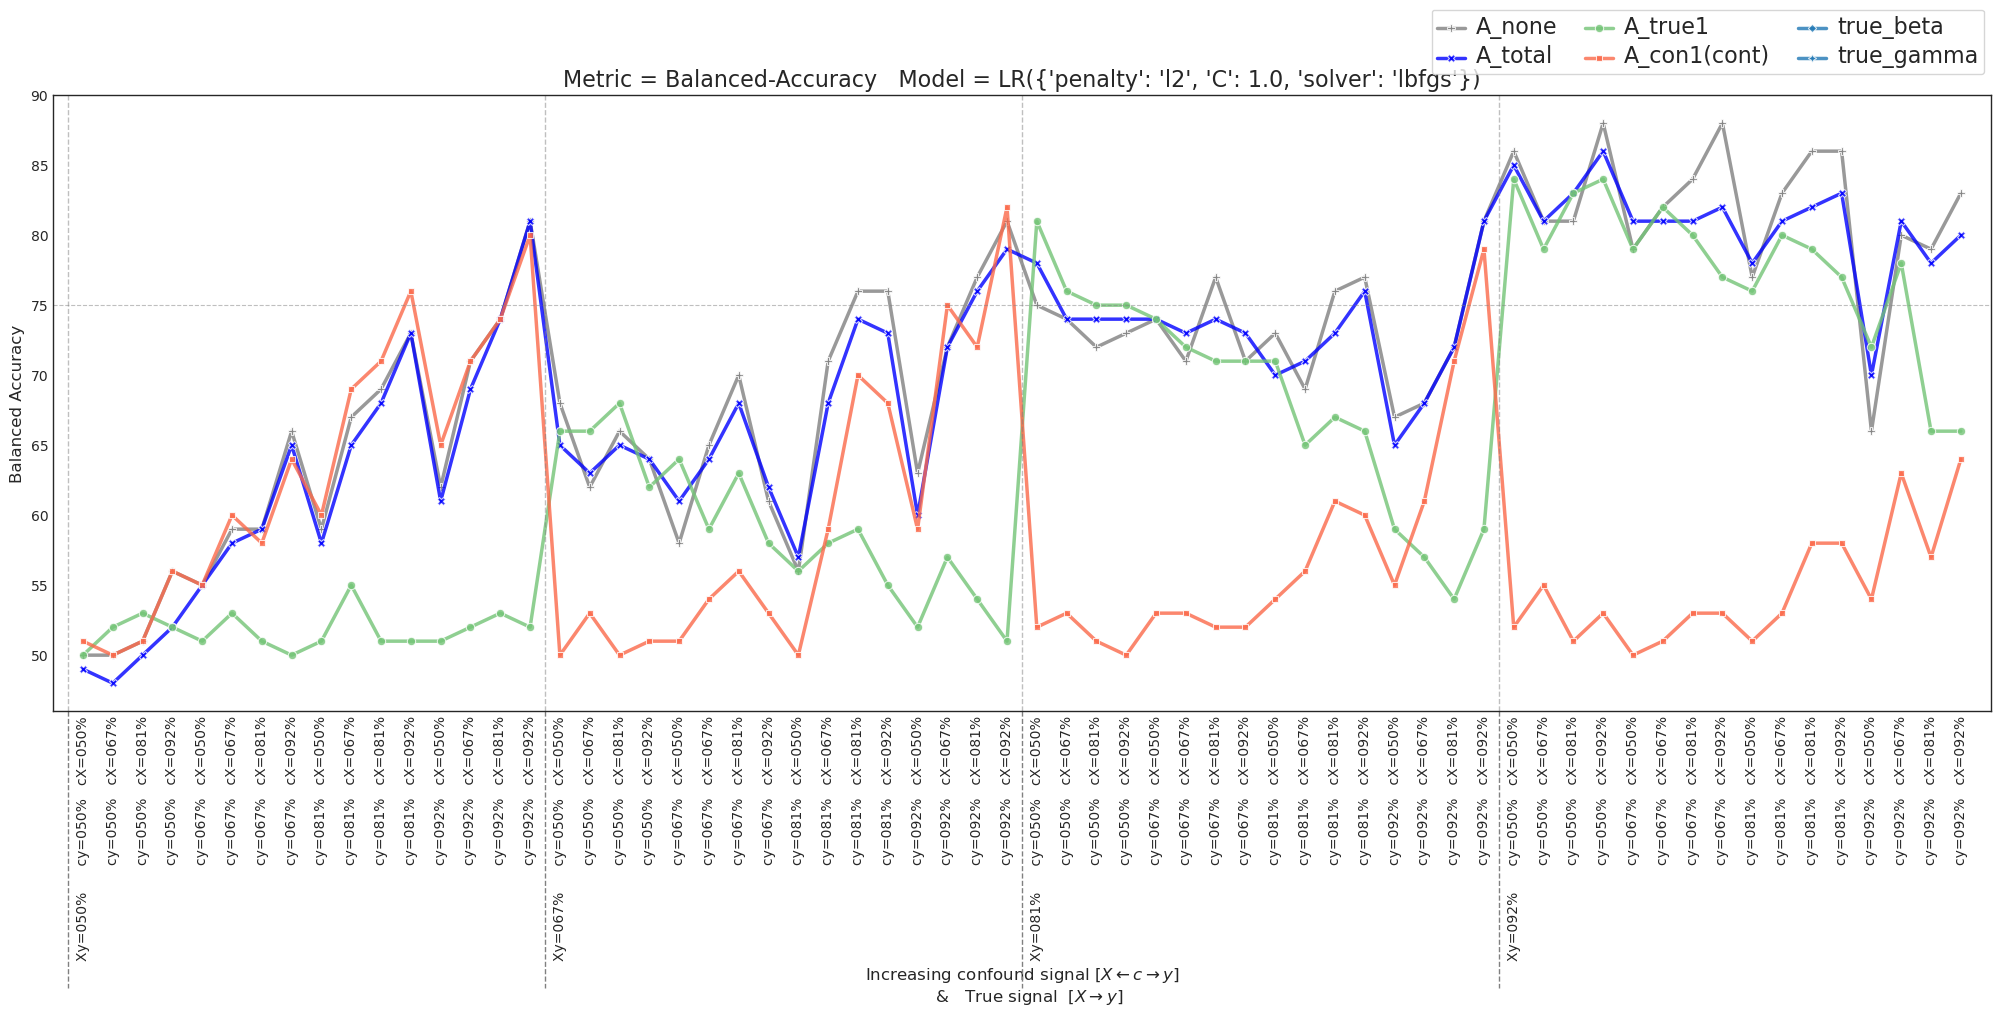

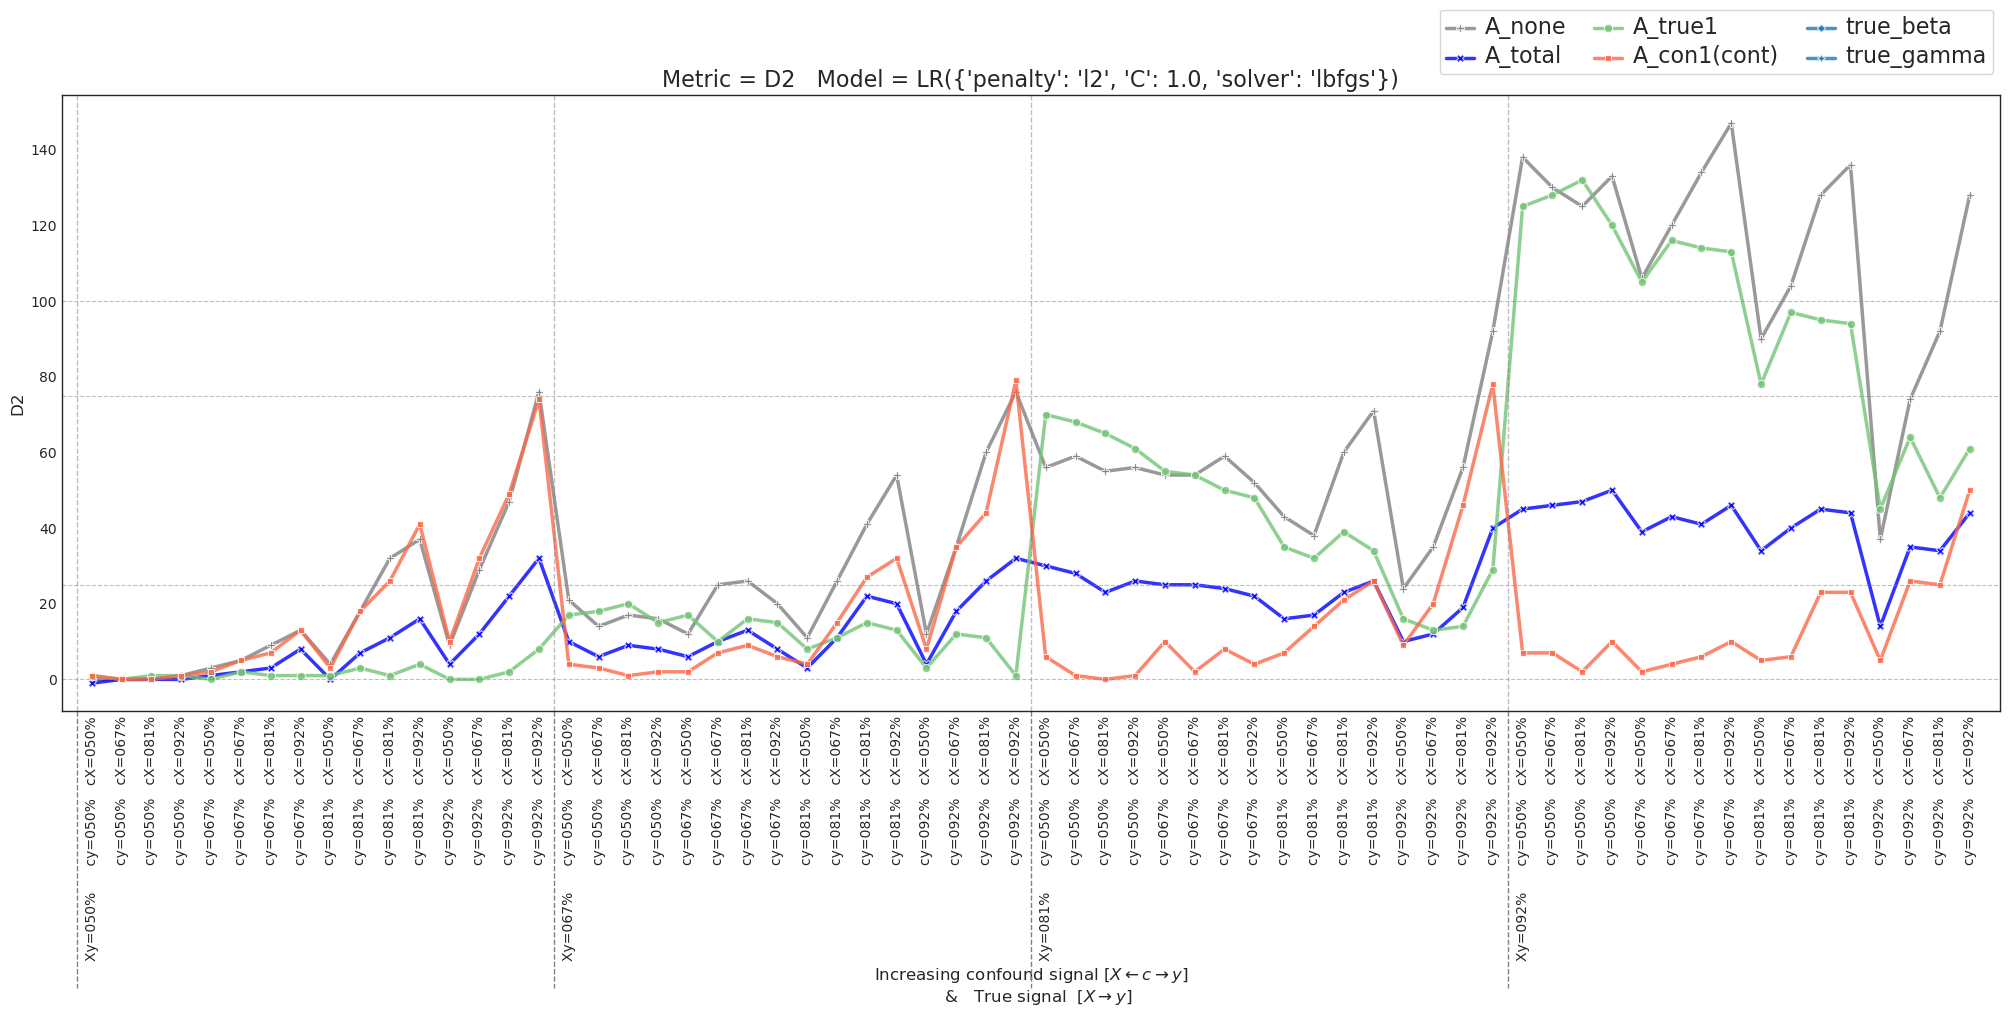

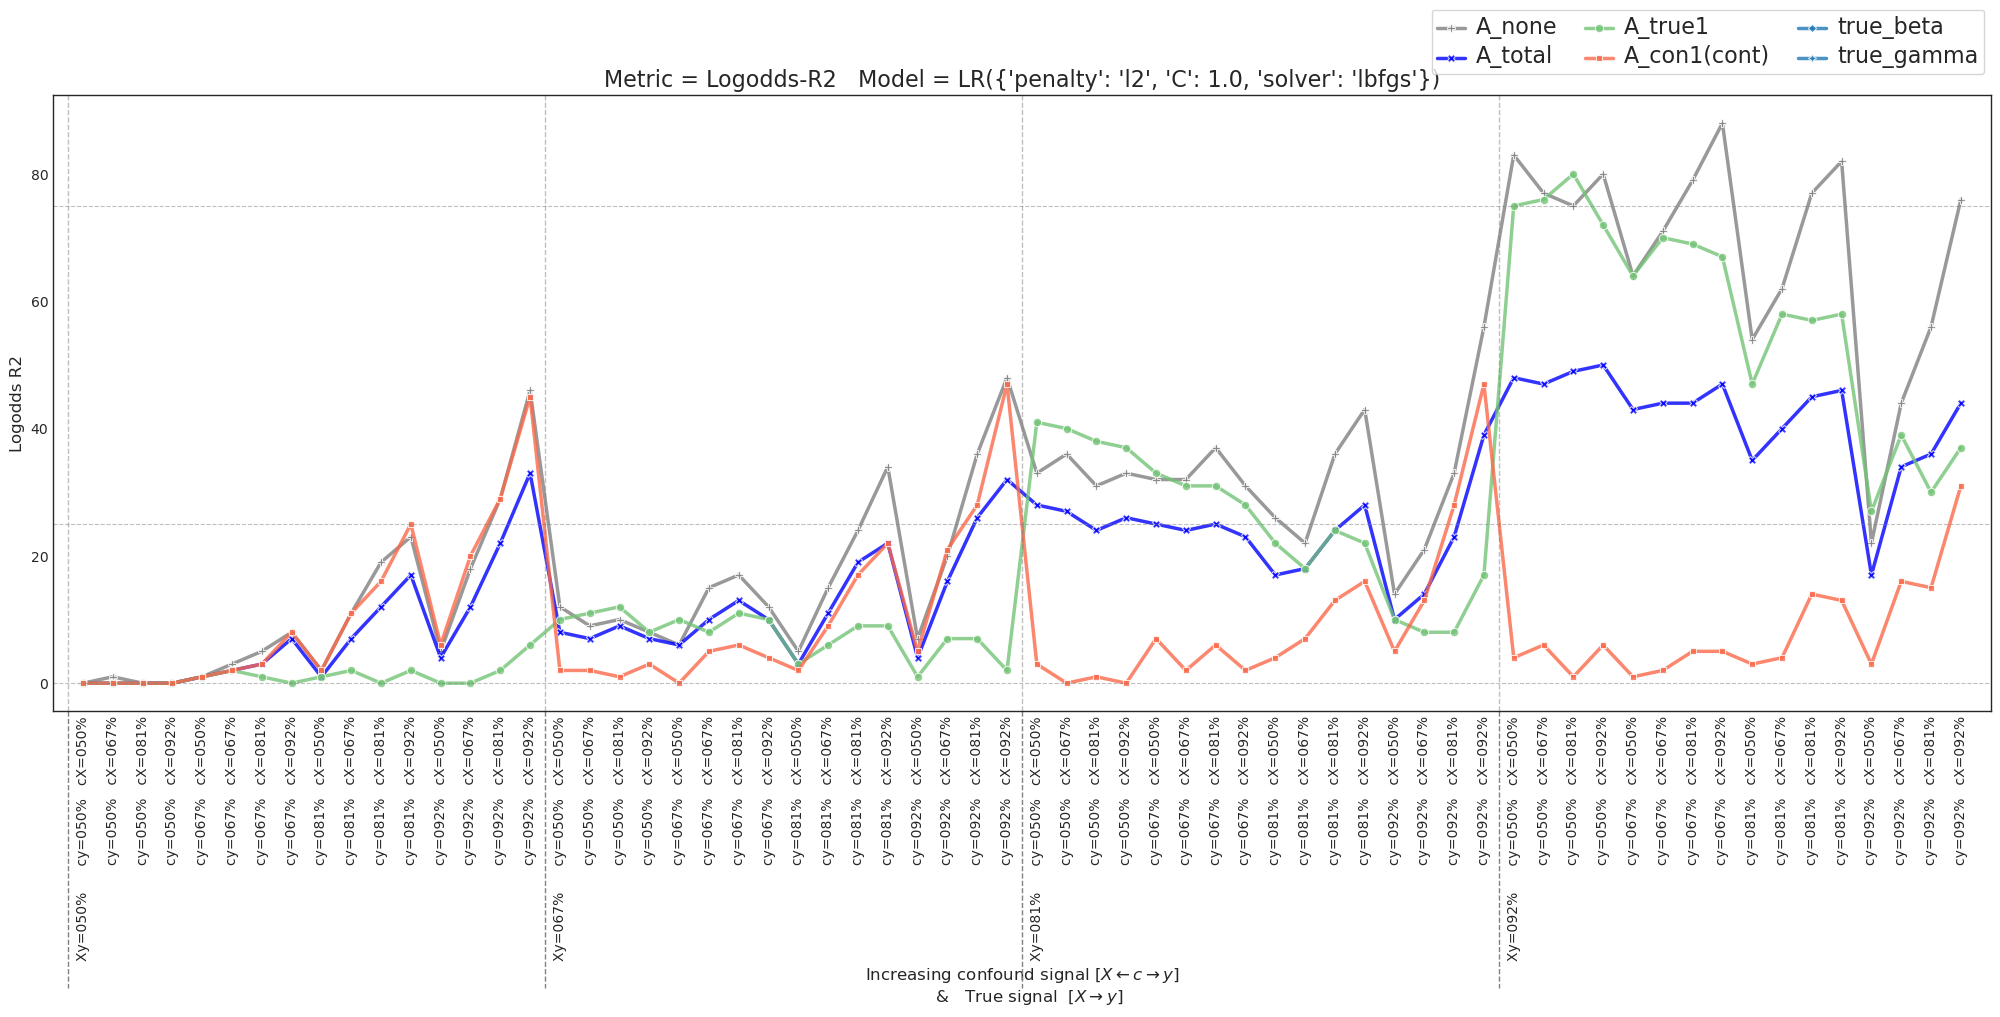

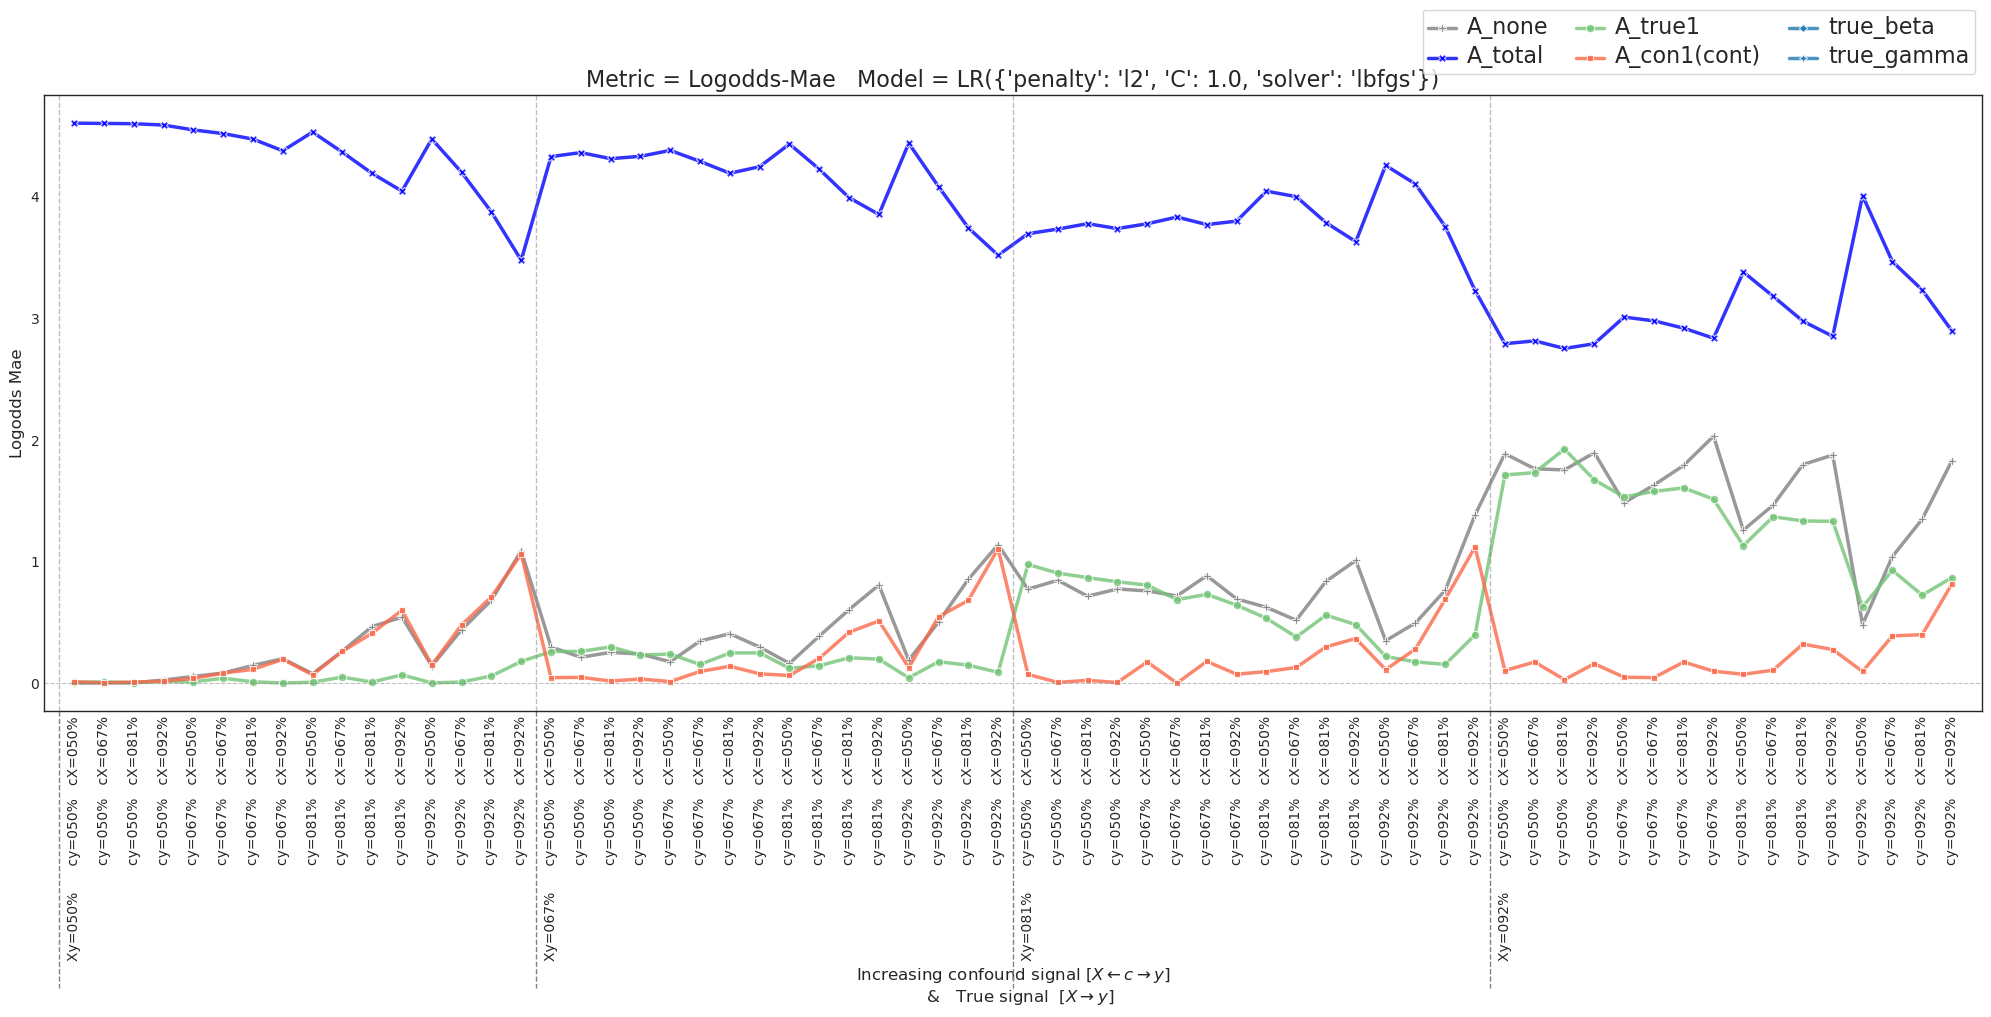

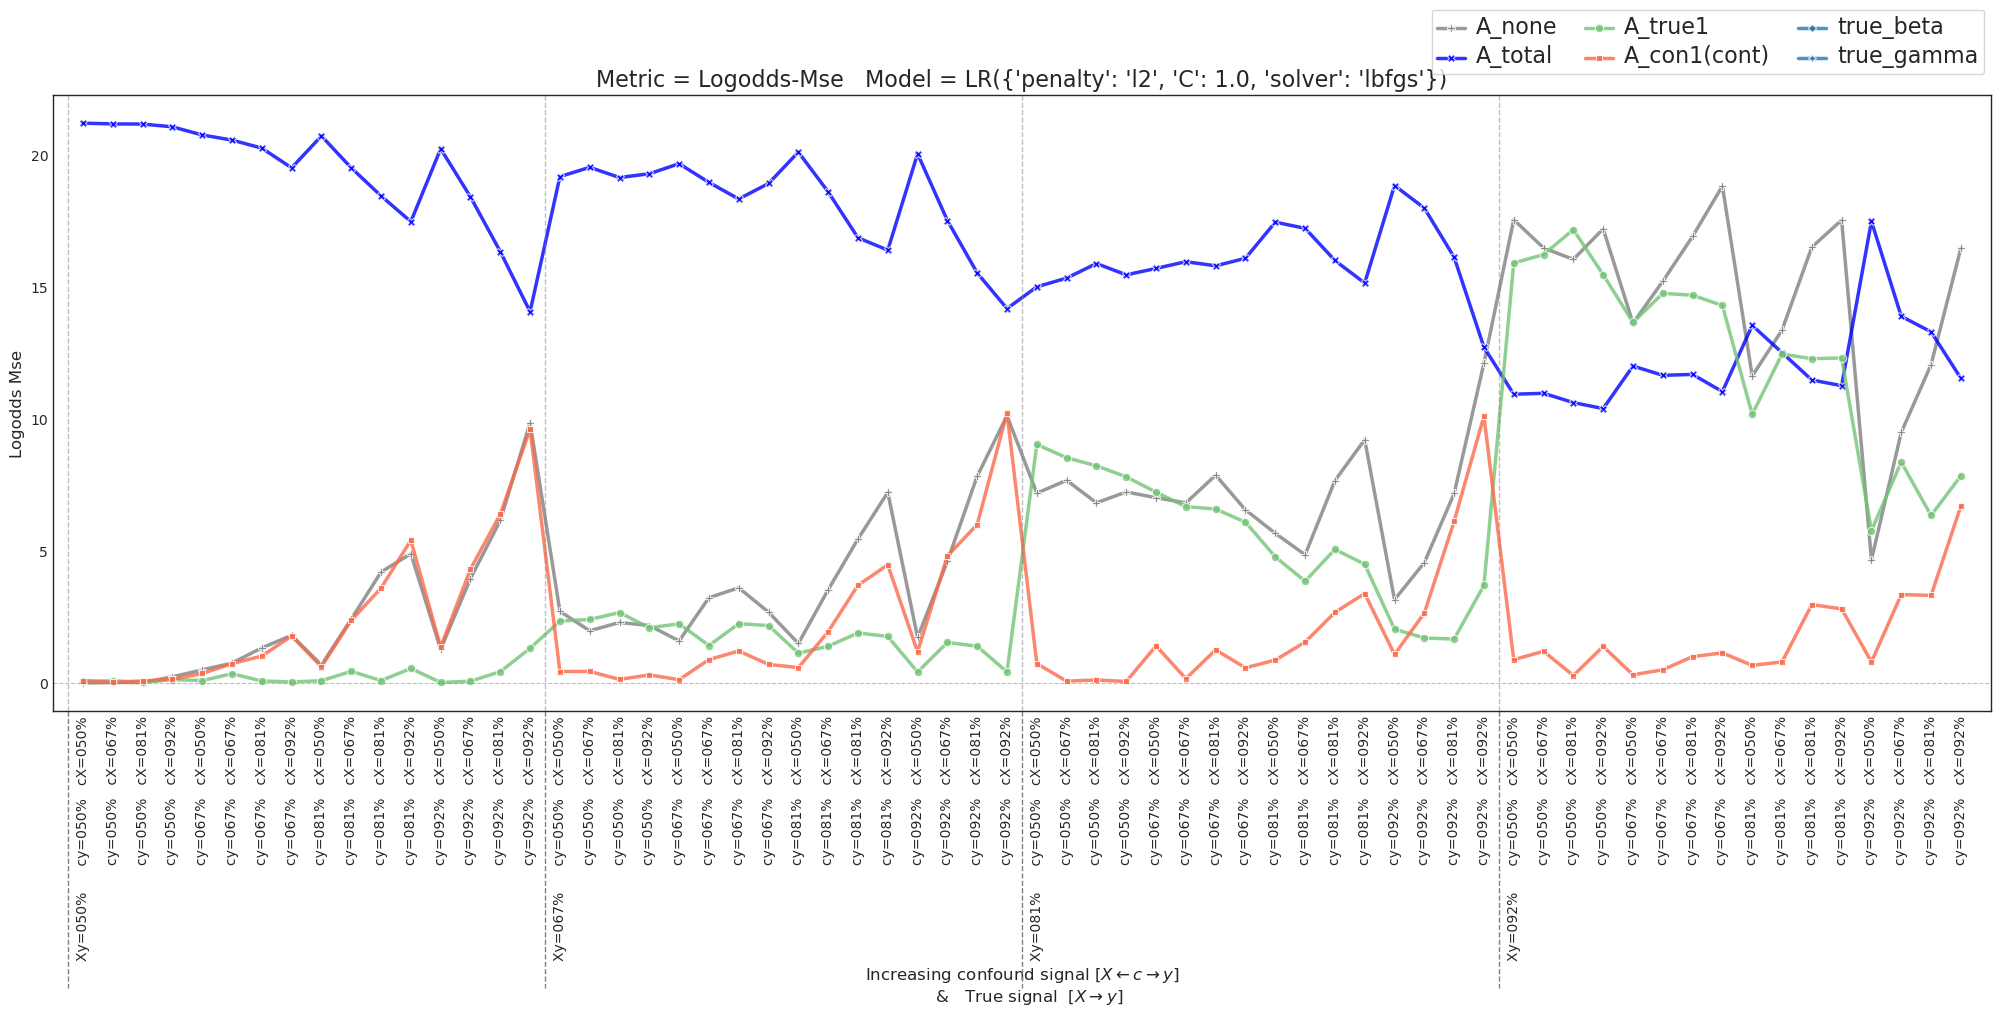

In [23]:
if VIZ_BASELINE:
    for metric, results in results_metrics.items():

        df = deepcopy(results)

        if len(dfs)<=5: # bar plot 
            show_scores_barplot(df, metric=metric, effect_mul=EFFECT_MUL)

        else: # line plot 
            df = df.reset_index()
            # set only 'dataset' as the index
            df = df.set_index('dataset')
            show_scores_lineplot(df, metric=metric,
                                con_names=covs_con, true_names=[lat_direct],
                                subtract_A_total=True,
                                # force_neg_to_zero=True if ('r2' in metric) or ('d2' in metric) else False, 
                                # show_A_sum=True if ('mae' not in metric) and ('mse' not in metric) else False, 
                                show_A_none=True)
        # save the plots
        con_types = [c.split('_')[-1] for c in covs_con]
        con_types = '-'.join(con_types)
        plt.show()

[TODO] $A_{total}$ decomposed
<!-- ### $A_{total}$ decomposed into $f (A_{cov}, A_{true}, A_{others}) $ 

# if VIZ_BASELINE:

#     for metric, results in results_metrics.items():
#     # reload the baseline results without averaging over all trials
#         results = show_contrib_table(dfs, 
#                                 avg_over_trials=False,
#                                 filter_cols=dfs[0].filter(regex=f'^score_holdout_.*_{metric}').columns.tolist())
                                
#         show_scores_decomp(results.data.reset_index(), 
#                         true_names=[true_attr], # TODO extend to multiple covs_enc
#                         metric=metric, center_metric=True)
#         plt.savefig(f'../../figures/sim_toybrains/decomp_ncons-{n_covs_enc}_type-{con_types}_ncovstolbl-{n_covs_lbl}_{metric}.png', bbox_inches='tight')
#         plt.show()
-->